In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

In [17]:
def create_dataframe_from_hive_mart_table(column_prefix,target_columns):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        A.dt_create_utc as dt,
        A.low as low,
        A.high as high,
        A.open as open,
        A.close as close,
        A.amount as volume,
        A.quantity as quantity,
        B.macd as macd,
        B.macd_single as macd_single,
        B.rsi as rsi
    from 
        hive.crypto_raw.candles_day as A
    left join
        hive.crypto_mart.crypto_indicator_day as B
    on A.dt_create_utc = B.dt and A.id = B.id
    where
        A.id = 'BTC_USDT'
    order by A.dt_create_utc
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df

In [41]:
########################
# Load BTC_USDT OHLC and indicators
########################
column_prefix = "btc_"
target_columns = [
        'dt',
        'low',
        'high',
        'open',
        'close',
        'volume',
        'quantity',
        'macd',
        'macd_single',
        'rsi'
]
btc_raw_df = create_dataframe_from_hive_mart_table(column_prefix,target_columns)
btc_raw_df = btc_raw_df.fillna(method='ffill') # First, fill it with data in most previous date
btc_raw_df = btc_raw_df.fillna(method='bfill') # Second, fill it with data in most future date

btc_raw_df.tail()

,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_quantity,btc_macd,btc_macd_single,btc_rsi
1067,2023-10-03,27174.00,27668.44,27491.34,27426.56,85231336.0,3100.506800,216.80441,78.34773,58.583668
1068,2023-10-04,27226.34,27826.31,27414.54,27782.28,68025576.0,2472.400100,261.73267,115.02472,62.254440
1069,2023-10-05,27363.09,28108.24,27777.34,27406.73,59149012.0,2140.965800,263.99185,144.81815,56.555374
1070,2023-10-06,27195.56,28261.63,27411.81,27930.84,66318732.0,2393.283700,304.56268,176.76706,61.809803
1071,2023-10-07,27844.51,27957.90,27928.48,27939.13,3145491.8,112.683754,333.53955,208.12155,61.888330


In [42]:
####################################
# Create Dataset with target value
####################################

# Check if all "date" exist in the dataframe.
first_dt = str(btc_raw_df.iloc[0]['btc_dt'])
last_dt = str(btc_raw_df.iloc[-1]['btc_dt'])
desired_date_range = pd.date_range(start=first_dt, end=last_dt, freq='D')
all_dates_exist = all(str(date)[:11].strip() == str(btc_raw_df.iloc[i]['btc_dt']).strip() for i,date in enumerate(desired_date_range))
if all_dates_exist:
    print("All dates exist in the DataFrame's index.")
else:
    print("Not all dates exist in the DataFrame's index.")

btc_df_with_target = btc_raw_df

# Create target value to predict
# Predict the "close" value after N days.
predicting_days = 1
target = btc_raw_df['btc_close'].shift(-predicting_days)
btc_df_with_target['target'] = target

btc_df_with_target.tail()

All dates exist in the DataFrame's index.


,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_quantity,btc_macd,btc_macd_single,btc_rsi,target
1067,2023-10-03,27174.00,27668.44,27491.34,27426.56,85231336.0,3100.506800,216.80441,78.34773,58.583668,27782.28
1068,2023-10-04,27226.34,27826.31,27414.54,27782.28,68025576.0,2472.400100,261.73267,115.02472,62.254440,27406.73
1069,2023-10-05,27363.09,28108.24,27777.34,27406.73,59149012.0,2140.965800,263.99185,144.81815,56.555374,27930.84
1070,2023-10-06,27195.56,28261.63,27411.81,27930.84,66318732.0,2393.283700,304.56268,176.76706,61.809803,27939.13
1071,2023-10-07,27844.51,27957.90,27928.48,27939.13,3145491.8,112.683754,333.53955,208.12155,61.888330,NaN


In [43]:
btc_df_with_target.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_quantity,btc_macd,btc_macd_single,btc_rsi,target
count,1071.000000,1071.000000,1071.000000,1071.000000,1.071000e+03,1071.000000,1071.000000,1071.000000,1071.000000,1070.000000
mean,32799.986088,34596.193296,33744.493305,33758.390009,2.796247e+07,818.602274,104.205527,101.850279,51.290206,33777.092009
std,12634.159601,13493.872550,13112.290872,13099.375085,3.613648e+07,1129.437331,1592.620760,1513.801512,13.715324,13091.187761
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,0.083530,-5075.484400,-4436.556600,17.769420,13558.840000
25%,22355.895000,23319.465000,22863.785000,22923.605000,4.767987e+06,189.886520,-795.722335,-716.387450,41.304417,22936.877500
50%,29400.000000,30525.430000,30077.960000,30079.030000,1.469921e+07,407.269100,-47.150450,-75.886430,49.564484,30079.125000
75%,42135.025000,44256.500000,43146.000000,43149.225000,3.648858e+07,1011.599450,1076.801100,1078.357550,60.444465,43151.762500
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,8847.044000,5248.708500,4504.263000,89.626370,67523.940000


In [44]:
# Drop date column
btc_dt = btc_df_with_target['btc_dt']
dataset_raw_df = btc_df_with_target.drop(['btc_dt'], axis=1)
dataset_raw_df.tail()

,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_quantity,btc_macd,btc_macd_single,btc_rsi,target
1067,27174.00,27668.44,27491.34,27426.56,85231336.0,3100.506800,216.80441,78.34773,58.583668,27782.28
1068,27226.34,27826.31,27414.54,27782.28,68025576.0,2472.400100,261.73267,115.02472,62.254440,27406.73
1069,27363.09,28108.24,27777.34,27406.73,59149012.0,2140.965800,263.99185,144.81815,56.555374,27930.84
1070,27195.56,28261.63,27411.81,27930.84,66318732.0,2393.283700,304.56268,176.76706,61.809803,27939.13
1071,27844.51,27957.90,27928.48,27939.13,3145491.8,112.683754,333.53955,208.12155,61.888330,NaN


In [45]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = list(dataset_raw_df.columns)
feature_columns.remove('target')
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(1071, 9)


array([[0.00778521, 0.00114998, 0.00434979, ..., 0.62150379, 0.62361326,
        0.74313972],
       [0.        , 0.        , 0.00359652, ..., 0.62150379, 0.62361326,
        0.74313972],
       [0.0015097 , 0.00401577, 0.        , ..., 0.62150379, 0.62361326,
        0.74313972],
       ...,
       [0.26679933, 0.25887159, 0.26372644, ..., 0.51718098, 0.51241105,
        0.53976622],
       [0.26364178, 0.26165165, 0.25694788, ..., 0.52111067, 0.51598442,
        0.61288968],
       [0.27587296, 0.25614681, 0.26652925, ..., 0.52391737, 0.51949132,
        0.6139825 ]])

In [46]:
sc_target = MinMaxScaler(feature_range = (0,1))
feature_columns = ['target']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[feature_columns])
print('dataset_target_scaled:',dataset_target_scaled.shape)
dataset_target_scaled

dataset_target_scaled: (1071, 1)


array([[0.        ],
       [0.00844527],
       [0.01064781],
       ...,
       [0.26632027],
       [0.26647389],
       [       nan]])

In [65]:
# Add past close price data to the dataset.
"""
    X_train[i,0]: btc_low
    X_train[i,1]: btc_high
    X_train[i,2]: btc_open
    X_train[i,3]: btc_close
    X_train[i,4]: btc_volume
    X_train[i,5]: = X_train[i-N+1,5]
    X_train[i,6]: = X_train[i-N+2,5]
    X_train[i,7]: = X_train[i-N+3,5]
    X_train[i,8]: = X_train[i-N+4,5]
    X_train[i,9]: = X_train[i-N+5,5]
    X_train[i,10]: = X_train[i-N+6,5]
"""
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],
         dataset_feature_scaled[i-past_N+1:i].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i, 0:dataset_feature_scaled.shape[1]],
         dataset_feature_scaled[i-past_N+1:i].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (846, 90)
X_test shape (215, 90)


In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping


In [79]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(BatchNormalization())
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')
regressor.summary()
# callback = EarlyStopping(monitor='val_loss', patience=10)

# history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split=0.1, shuffle=True, callbacks=[callback])
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split=0.1, shuffle=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 90, 50)            10400     
                                                                 
 dropout_29 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_36 (LSTM)              (None, 90, 50)            20200     
                                                                 
 dropout_30 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 90, 50)            20200     
                                                                 
 dropout_31 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_38 (LSTM)              (None, 50)               

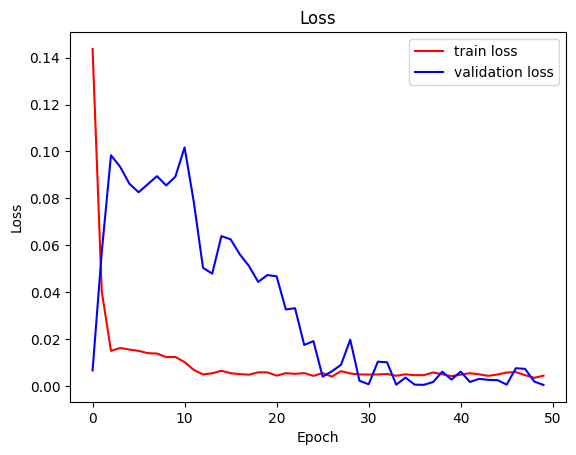

In [80]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-1]
print('predicted_price shape:',predicted_price.shape)
predicted_price

7/7 [==============================] - 1s 16ms/step
predicted_price shape: (214, 1)


array([[21760.098],
       [21685.74 ],
       [21428.082],
       [20563.668],
       [18901.508],
       [18532.89 ],
       [19048.162],
       [21739.492],
       [24738.533],
       [24893.531],
       [24637.951],
       [25932.453],
       [27824.479],
       [27703.557],
       [28339.691],
       [28119.562],
       [28455.584],
       [27627.666],
       [28253.594],
       [27336.746],
       [27458.316],
       [27732.066],
       [26827.438],
       [27246.566],
       [28369.422],
       [27859.402],
       [28377.59 ],
       [28318.309],
       [27988.62 ],
       [27581.244],
       [28054.52 ],
       [27924.852],
       [27789.18 ],
       [27685.418],
       [27703.795],
       [28416.416],
       [30017.137],
       [30596.666],
       [30230.553],
       [30749.176],
       [30790.049],
       [30571.748],
       [30659.795],
       [29253.232],
       [30387.273],
       [28183.71 ],
       [27319.473],
       [26202.738],
       [26778.494],
       [26592.645],


In [82]:
real_price = dataset_raw_df['target'].iloc[train_index_to:test_index_to].values.reshape(-1,1)[:-1]
print('real_price shape:',real_price.shape)
real_price

real_price shape: (214, 1)


array([[21702.16],
       [20356.73],
       [20161.29],
       [20460.09],
       [21981.89],
       [24101.53],
       [24690.97],
       [24274.61],
       [24997.72],
       [27384.12],
       [26905.78],
       [27955.25],
       [27718.1 ],
       [28108.27],
       [27250.91],
       [28287.79],
       [27440.7 ],
       [27470.19],
       [27968.27],
       [27116.04],
       [27259.81],
       [28350.29],
       [28032.83],
       [28469.67],
       [28455.58],
       [28171.86],
       [27802.75],
       [28164.56],
       [28173.02],
       [28014.35],
       [27909.12],
       [27926.9 ],
       [28319.67],
       [29642.3 ],
       [30203.37],
       [29886.18],
       [30383.74],
       [30469.65],
       [30298.12],
       [30304.37],
       [29427.34],
       [30383.04],
       [28782.58],
       [28240.45],
       [27265.56],
       [27815.64],
       [27593.32],
       [27511.41],
       [28299.91],
       [28419.76],
       [29474.99],
       [29312.99],
       [2922

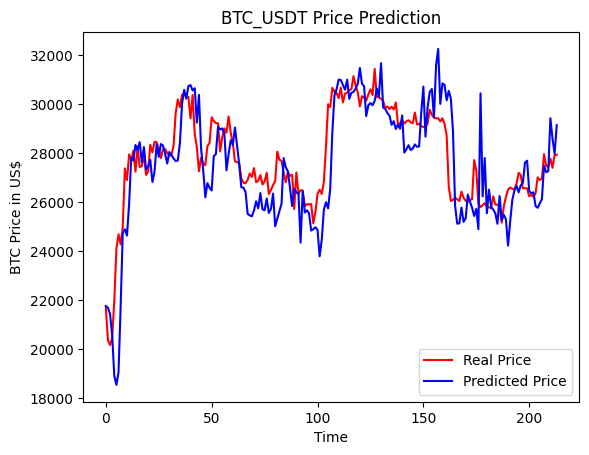

In [83]:
plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [87]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_train)
predicted_price = sc_target.inverse_transform(predicted_price)
print('predicted_price shape:',predicted_price.shape)
predicted_price

27/27 [==============================] - 0s 17ms/step
predicted_price shape: (846, 1)


array([[16432.654 ],
       [17017.172 ],
       [17233.498 ],
       [17397.672 ],
       [17471.8   ],
       [17136.7   ],
       [17479.865 ],
       [18316.877 ],
       [19733.729 ],
       [19407.592 ],
       [20267.54  ],
       [20620.398 ],
       [20811.566 ],
       [20263.695 ],
       [20488.54  ],
       [21206.197 ],
       [21083.133 ],
       [17282.916 ],
       [18211.035 ],
       [18569.668 ],
       [19564.893 ],
       [20741.547 ],
       [19655.666 ],
       [20154.805 ],
       [20368.273 ],
       [19132.295 ],
       [19788.152 ],
       [19941.012 ],
       [19928.57  ],
       [18565.002 ],
       [18902.682 ],
       [18532.877 ],
       [18291.672 ],
       [19276.422 ],
       [19723.77  ],
       [19855.54  ],
       [20664.342 ],
       [23418.57  ],
       [23814.688 ],
       [25171.53  ],
       [25206.604 ],
       [25081.459 ],
       [23665.752 ],
       [25066.678 ],
       [23912.414 ],
       [24914.793 ],
       [26224.488 ],
       [28135

In [88]:
real_price = dataset_raw_df['target'].iloc[:train_index_to].values.reshape(-1,1)
print('real_price shape:',real_price.shape)
real_price

real_price shape: (856, 1)


array([[13558.84],
       [14014.59],
       [14133.45],
       [15586.95],
       [15579.32],
       [14817.41],
       [15470.96],
       [15316.51],
       [15303.  ],
       [15686.8 ],
       [16292.95],
       [16319.49],
       [16060.8 ],
       [15947.27],
       [16711.46],
       [17652.77],
       [17778.24],
       [17802.86],
       [18656.04],
       [18705.13],
       [18418.9 ],
       [18372.64],
       [19157.86],
       [18736.61],
       [17146.01],
       [17135.64],
       [17727.52],
       [18174.53],
       [19687.74],
       [18763.44],
       [19225.36],
       [19428.82],
       [18661.57],
       [19153.89],
       [19365.67],
       [19179.75],
       [18330.  ],
       [18554.97],
       [18241.22],
       [18020.4 ],
       [18806.43],
       [19173.09],
       [19278.77],
       [19426.77],
       [21329.05],
       [22800.28],
       [23102.46],
       [23821.7 ],
       [23488.58],
       [22713.86],
       [23808.33],
       [23235.17],
       [2373

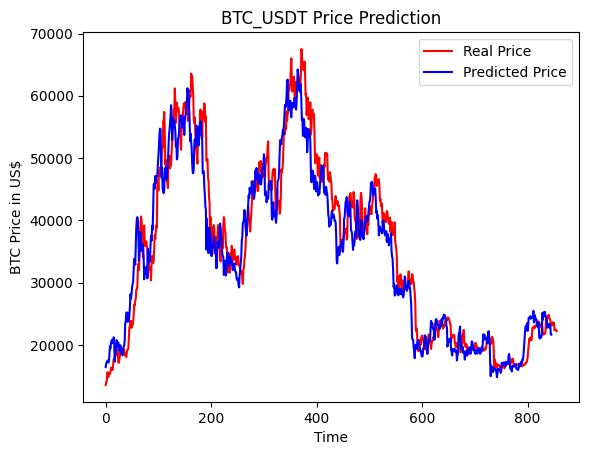

In [89]:
plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()